# Notebook to test methods for spike clustering that are specific to power muscle spikes

In particular, want to try sorting based on amplitude and other spike characteristics

## Imports

In [1]:
import os 
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal

from mosquito.util import idx_by_thresh, butter_highpass_filter, butter_bandpass_filter
from mosquito.process_abf import load_processed_data, detrend_emg, cluster_spikes

## Params

In [2]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels


In [3]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#8dd3c7', '#feffb3', '#bfbbd9', '#fa8174', '#81b1d2', '#fdb462', '#b3de69', '#bc82bd', '#ccebc4', '#ffed6f']


## Load data

In [4]:
# load processed data
data_root = '/media/sam/SamData/Mosquitoes'
data_folder =  '28_20240529'  # '22_20240516'  #   '27_20240528'  # '28_20240529'  #  '17_20240507'
axo_num = 11 # 7  # 3  #    0
# vid_str = 'aedes_C001H001S0001_20240326_154951'
data = load_processed_data(data_folder, axo_num)

In [5]:
# read data into memory
t = data['time']  
emg_filt = data['emg_filt']
emg = data['emg']
spike_idx = data['spike_idx']
spikes = data['spikes'] 
spike_t = data['spike_t'] 
spike_rate = data['spike_rate']

window = data['params']['emg_window']
offset = data['params']['emg_offset'] 
fs = data['sampling_freq']

## Visualize spikes

Text(0, 0.5, 'emg (V)')

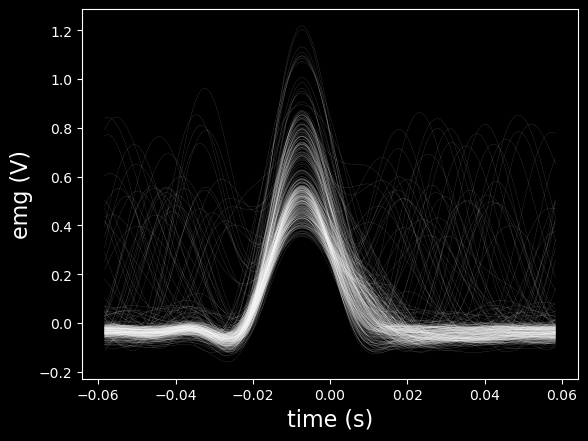

In [6]:
# plot spikes as extracted
fig, ax = plt.subplots()

for spike in spikes:
    ax.plot(spike_t, spike, 'w-', lw=0.2, alpha=0.3)
    
ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')
# ax.set_xlim([-0.02, 0.005])

In [7]:
# # try to realign and visualize?
# # loop through and align spikes to new threshold
# spikes_realigned = list()
# spike_realigned_idx = list()
# thresh =0.5 # 0.1  # 1

# for idx in spike_idx:
#     # get spike in current window
#     idx_range = np.arange(idx - window, idx + window)
#     spike = emg[idx_range]

#     # subtract off value at initial time point
#     spike -= spike[0]

#     # find first instance of thresh crossing
#     try:
#         thresh_idx = np.where(spike > thresh)[0][0]
#     except IndexError:
#         continue
        
#     thresh_idx += (idx - window)
#     spike_realigned_idx.append(thresh_idx)

#     # get spike in this new window
#     spike_new = emg[slice(thresh_idx - window, thresh_idx + 2*window)]
#     # spike_new -= spike_new[0]
#     spikes_realigned.append(spike_new)

In [8]:
# might be easier with non-filtered spikes
spikes_raw = []
for idx in spike_idx:
    idx_start = (idx - offset) - window
    idx_end = (idx - offset) + window
    spike_curr = emg[idx_start:idx_end].copy()
    spike_curr -= np.median(spike_curr[:window])
    spikes_raw.append(spike_curr)


Text(0, 0.5, 'emg (V)')

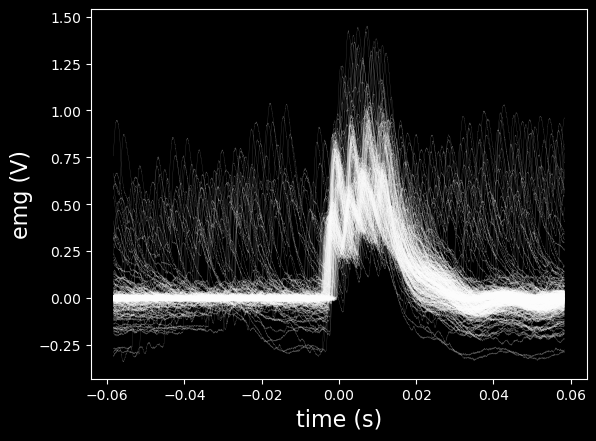

In [9]:
# plot raw spikes
fig, ax = plt.subplots()

for spike in spikes_raw:
    ax.plot(spike_t, spike, 'w-', lw=0.2, alpha=0.3)
    
ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')

In [10]:
# # what is the deal with jumps in data?
# low_idx = np.where(np.min(np.vstack(spikes_raw), axis=1) < -2)[0]
# # print(low_idx)
# ind = 2
# mask = np.arange(spike_idx[low_idx[ind]] - 3*window, spike_idx[low_idx[ind]] + 3*window)
# fig, ax = plt.subplots()

# ax.plot(t[mask], emg[mask])

## Extract features we might want to use for clustering

In [11]:
# spike amplitude is probably going to be the most important piece here. 
# let's take the one that we've already calculated, rather than trying to find one again
spike_heights = np.asarray([spike[window - offset] for spike in spikes])


In [12]:
# also get peak info from scipy signal
spike_widths, _, _, _ = signal.peak_widths(emg_filt, spike_idx)
spike_prominences, _, _ = signal.peak_prominences(emg_filt, spike_idx)


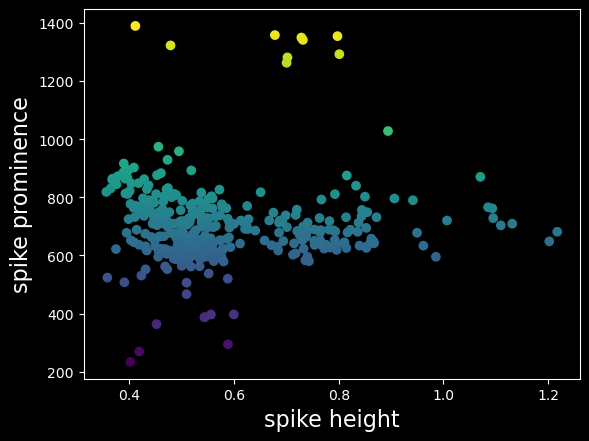

In [13]:
# see if just these three give any separation 
fig, ax = plt.subplots()
ax.scatter(spike_heights, spike_widths, c=spike_widths)
ax.set_xlabel('spike height')
ax.set_ylabel('spike prominence')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## How does this approach compare to PCA?

Text(0, 0.5, 'emg (V)')

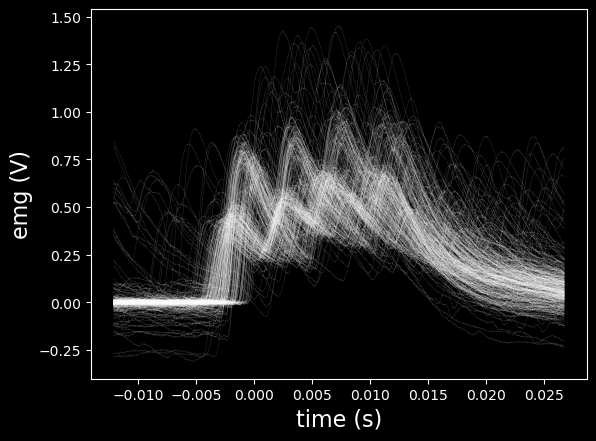

In [14]:
# try a narrorwer window for spike
# spike_arr = np.vstack(spikes)
# idx1 = (window - offset) - round(window/3)
# idx2 = (window - offset) + round(window/3)

spike_arr = np.vstack(spikes_raw)
idx1 = (window + offset) - round(window/3)
idx2 = (window + offset) + round(window/3)

spike_arr_narrow = spike_arr[:, idx1:idx2]

fig, ax = plt.subplots()
for spike in spike_arr:
    ax.plot(spike_t[idx1:idx2], spike[idx1:idx2], 'w-', lw=0.2, alpha=0.3)
    
ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')

In [15]:
# how does this compare to PCA?
from sklearn.decomposition import PCA


pca = PCA(n_components=20)  # PCA(n_components=20)
pca.fit(spike_arr_narrow)
pca_result = pca.transform(spike_arr_narrow)

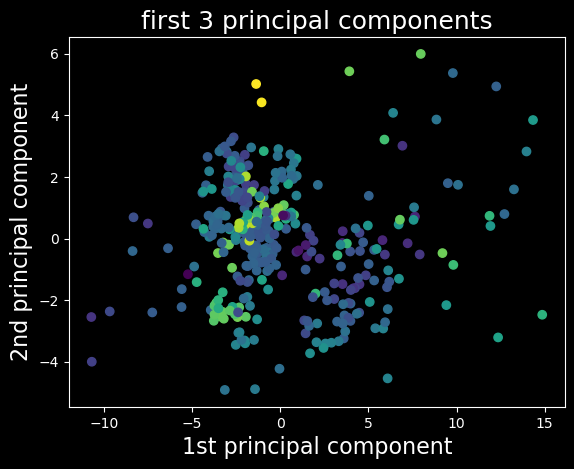

In [16]:
# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots()
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
ax.set_title('first 3 principal components')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3660919
For n_clusters = 3 The average silhouette_score is : 0.23785993
For n_clusters = 4 The average silhouette_score is : 0.2578131
For n_clusters = 5 The average silhouette_score is : 0.23529507
For n_clusters = 6 The average silhouette_score is : 0.21655037
For n_clusters = 7 The average silhouette_score is : 0.2245679
For n_clusters = 8 The average silhouette_score is : 0.1993336
For n_clusters = 9 The average silhouette_score is : 0.19529621
For n_clusters = 10 The average silhouette_score is : 0.19016528


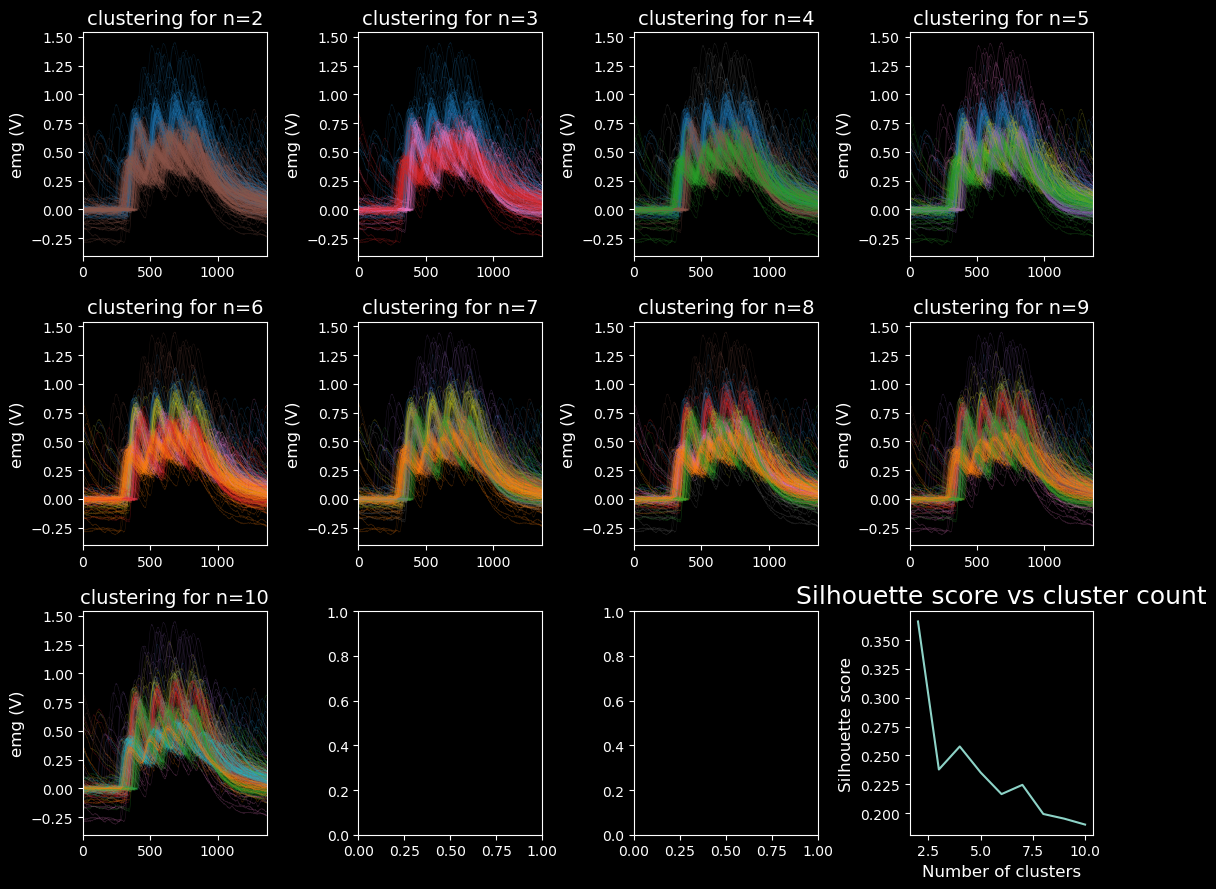

In [17]:
# need better visualization i think
cluster_num = None
cluster_labels = cluster_spikes(spike_arr_narrow, cluster_num=cluster_num, max_clust=10)

In [39]:
# need better visualization i think
cluster_num = 3 #  9
cluster_labels = cluster_spikes(spike_arr_narrow, cluster_num=cluster_num)

(0.0, 120.0)

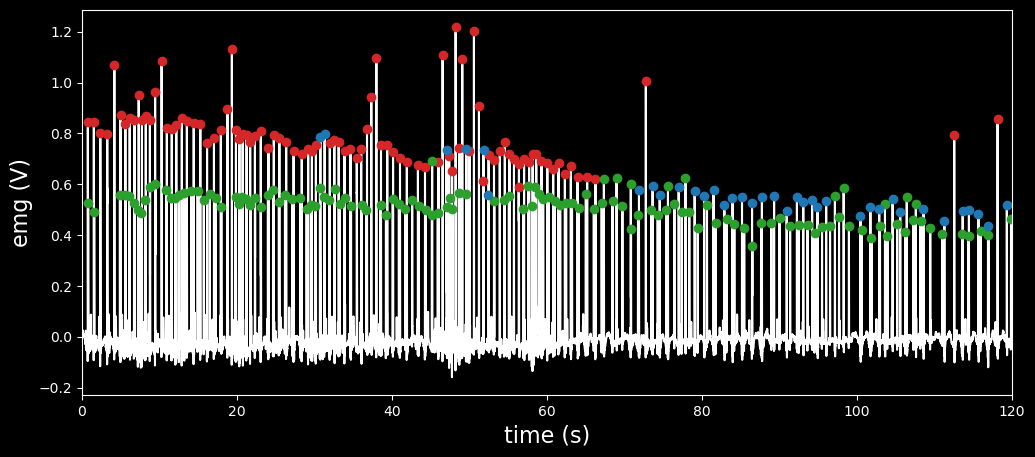

In [40]:
# visualize clustering in time series
fig, ax = plt.subplots(figsize=(12,5))

tmin = 0 # 10 + 4
tmax = 120 # 10 + 11
mask = (t >= tmin) & (t <= tmax)

# plot emg
ax.plot(t[mask], emg_filt[mask], 'w-')

# plot spike points colored by cluster
# colors = ['#8dd3c7', '#feffb3']
colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:gray', 'm', 'y']

for val, color in zip(np.unique(cluster_labels), colors):
    cluster_idx = (cluster_labels == val)
    ax.plot(t[spike_idx][cluster_idx], emg_filt[spike_idx][cluster_idx], 'o', color=color)

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')
ax.set_xlim([tmin, tmax])
# ax.set_ylim([np.min(emg_

In [22]:
# # visualize clustering in time series
# fig, ax = plt.subplots(figsize=(12,5))

# tmin = 0# 10 + 4
# tmax = 20 # 10 + 11
# mask = (t >= tmin) & (t <= tmax)

# # plot emg
# ax.plot(t[mask], emg[mask], 'w-')

# ax.set_xlabel('time (s)')
# ax.set_ylabel('emg (V)')